<a href="https://colab.research.google.com/github/jchen8000/MachineLearning/blob/master/5%20Anomaly%20Detection/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection

***ABSTRACT***

There are different ways to detect anomaly data, this hands-on practice is to use Multivariate Gaussian Function as Supervised Anomaly Detection techniques, which the dataset with normal/abnormal labels are provided, and a Gaussian model is trained to detect the anomaly items.

We calculate the probability density for the 2-D dataset based on Multivariate Gaussian Function, then we find a threshold probability value, noted as $\epsilon$, so that the best [$F_1  score$](https://en.wikipedia.org/wiki/F1_score) is achieved, then every data item whose probability less than $\epsilon$ is deemed to be anomaly data.



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal

%matplotlib inline

## 1. Gaussian Distribution Functions

**Univariate Gaussian Function:**

$\qquad p(x;\mu,\sigma^2) =  \displaystyle\frac{1}{\sigma\sqrt{2\pi}}e^{-\displaystyle\frac{(\mu-x)^2}{2\sigma^2}}$


**Multivariate Gaussian Function**

$\qquad p(x; \mu, \Sigma)=\displaystyle\frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma|}}\exp\left(-\frac{1}{2}({x}-{\mu})^T{\boldsymbol\Sigma}^{-1}({x}-{\mu})\right)$

$\qquad where:$

$\qquad\qquad \mu_j = \displaystyle\frac{1}{m}\sum_{i=1}^mx_j^{(i)}, \qquad \sigma_j^2 = \displaystyle\frac{1}{m}\sum_{i=1}^m\left( x_j^{(i)} - \mu_j \right)^2$

### 1.1 Understand multivariate Gaussian

We plot several multivariate Gaussian functions with different $\mu$ and $\Sigma$.

for example,  
$\mu = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$, 
$ \Sigma = \begin{bmatrix} 10 & 0 \\0 & 10 \end{bmatrix}$

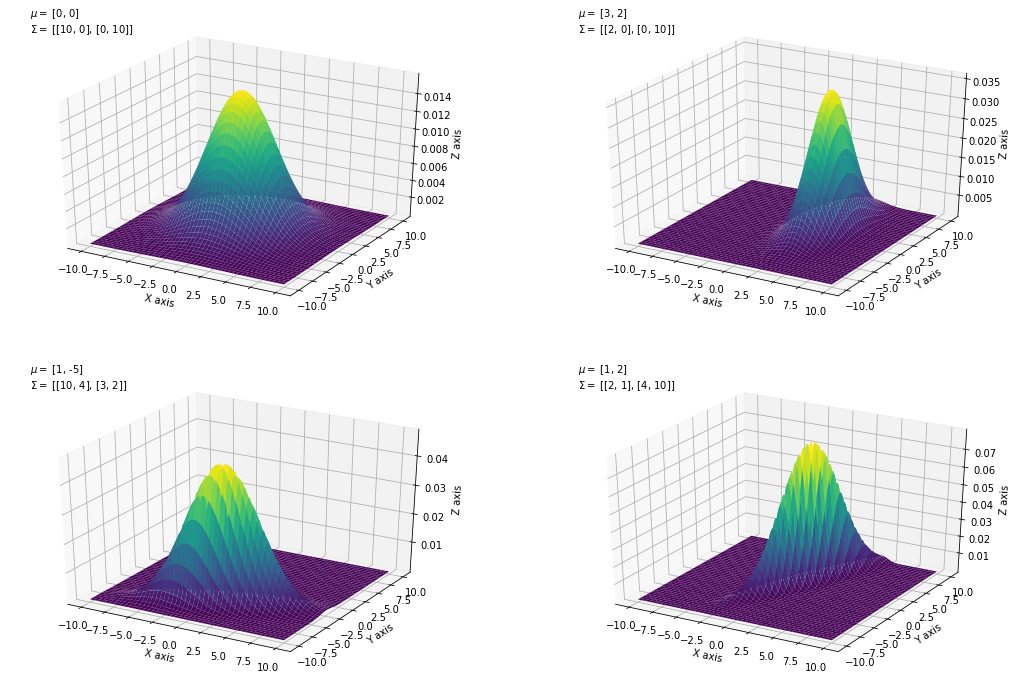

In [0]:
#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

mu_list = [[0,0],
           [3,2],
           [1,-5],
           [1,2] ]
sigma_list = [ [[10,0],[0,10]],
               [[2,0], [0,10]],
               [[10,4],[3,2]],
               [[2,1], [4,10]] ]

# Draw 3D multivariate Gaussian plots
fig = plt.figure(figsize=(18,12))
i = 0
for mu, sigma in zip(mu_list, sigma_list):
    rv = multivariate_normal(mu, sigma)
    i = i + 1
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
    ax.text2D(0.05, 0.95, "$\mu=$ %s\n$\Sigma=$ %s" % (mu,sigma), transform=ax.transAxes)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

plt.show()

### 1.2 Define Gaussian functions

In [0]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance
    var = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,var
  
  
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p
 

## 2. Anomaly Detection

### 2.1 Generate 2-D dataset with nomal data and anomaly data

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X_nom, y_nom = make_blobs(n_samples=600, centers=1, cluster_std=0.4, random_state=2)

#Add some anomaly points to the dataset
np.random.seed(2)
X_anm = np.random.normal(np.mean(X_nom, axis=0) , np.std(X_nom, axis=0) *4, size=[10, 2])
y_anm = np.ones(10)

X = np.concatenate((X_nom, X_anm))
y = np.concatenate((y_nom, y_anm))

In [0]:
mu, sigma2 = estimateGaussian(X)


In [0]:
print( "mu=", mu )
print( "mean", np.mean(X, axis=0))
print( "sigma", np.sqrt(sigma2) )
print( "std", np.std(X, axis=0))

mu= [-1.29929584 -9.5109783 ]
mean [-1.29929584 -9.5109783 ]
sigma [0.44565652 0.46062497]
std [0.44565652 0.46062497]


### 2.2 Plot the data

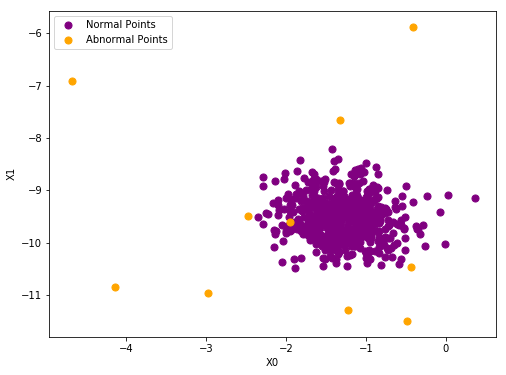

In [0]:
X_plot = np.column_stack([X, y])
#
# X_plot is used to plot the data
# X_plot[:,0] -> X1
# X_plot[:,1] -> X2
# X_plot[:,2] -> y (true lable)
#
#X_plot[np.where(X_plot[:,2] == 0.)]

plt.figure(figsize=(8,6))
plt.scatter(X_plot[np.where(X_plot[:,2] == 0.)][:, 0], X_plot[np.where(X_plot[:,2] == 0.)][:, 1], c='purple', s=50, label='Normal Points')
plt.scatter(X_plot[np.where(X_plot[:,2] == 1.)][:, 0], X_plot[np.where(X_plot[:,2] == 1.)][:, 1], c='orange', s=50, label='Abnormal Points')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.show()

### 2.3  Calculate the Probabilities using multivariate Gaussian function, and plot the data in 3D

In [0]:
p = multivariateGaussian(X, mu, sigma2)
X_plot = np.column_stack([X_plot, p])
#
# X_plot is used to plot the data
# X_plot[:,0] -> X1
# X_plot[:,1] -> X2
# X_plot[:,2] -> y (true lable)
# X_plot[:,3] -> Calculated probabilities
#

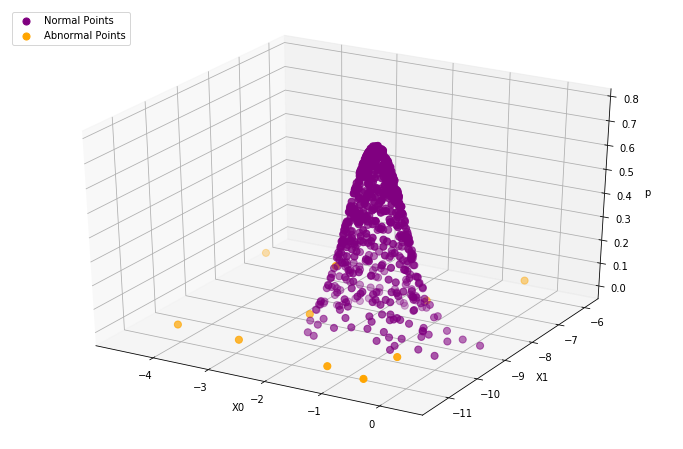

In [0]:
fig = plt.figure(figsize=(12, 8))

ax = fig.gca(projection='3d')
ax.grid(True)
ax.scatter3D(X_plot[np.where(X_plot[:,2] == 0.)][:, 0], X_plot[np.where(X_plot[:,2] == 0.)][:, 1], X_plot[np.where(X_plot[:,2] == 0.)][:, 3], c='purple', s=50, label='Normal Points')
ax.scatter3D(X_plot[np.where(X_plot[:,2] == 1.)][:, 0], X_plot[np.where(X_plot[:,2] == 1.)][:, 1], X_plot[np.where(X_plot[:,2] == 1.)][:, 3], c='orange', s=50, label='Abnormal Points')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('p')
plt.legend(loc=2)

plt.show()

### 2.4 Detect the anomaly data based on the Probabilities of Gaussian distribution

The data is distributed as Gaussian distribution, based on the calculated probabilities we can select a threshold so that if a data point's probability lower than the threshold, it is believed a anomaly data.

We will find this threshold, noted as **$\epsilon$**, by calculating the max [F1 score](https://en.wikipedia.org/wiki/F1_score).

In [0]:
from sklearn.metrics import f1_score

def selectThreshHold(yval, pval):
    
    f1 = 0
    bestF1 = 0
    bestEpsilon = 0
    
    stepsize = (np.max(pval) - np.min(pval)) / 1000
    epi_range = np.arange(pval.min(), pval.max(), stepsize)
    for epsilon in epi_range:

        pred = (pval < epsilon)
        
        f1 = f1_score(yval, pred, average='micro') 
        
        if f1 > bestF1:
            bestF1 = f1
            bestEpsilon = epsilon
            
    return bestF1, bestEpsilon
  

F1, epsilon = selectThreshHold(y, p)
print("Best F1 score = ", F1)
print("Anomaly threshHold = ", epsilon)

Best F1 score =  0.9934426229508196
Anomaly threshHold =  0.0007733970683526446


### 2.5 Plot the data again with anomaly detected in 2D and 3D

In [0]:
predict = (p < epsilon)
X_plot = np.column_stack([X_plot, predict])

#
# X_plot is used to plot the data
# X_plot[:,0] -> X1
# X_plot[:,1] -> X2
# X_plot[:,2] -> y (true lable)
# X_plot[:,3] -> Calculated probabilities
# X_plot[:,4] -> Predicted values
#

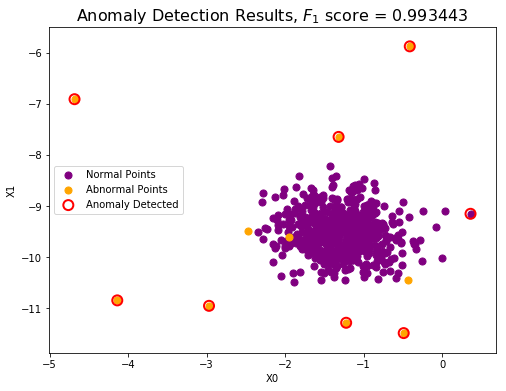

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X_plot[np.where(X_plot[:,2] == 0.)][:, 0], X_plot[np.where(X_plot[:,2] == 0.)][:, 1], c='purple', s=50, label='Normal Points')
plt.scatter(X_plot[np.where(X_plot[:,2] == 1.)][:, 0], X_plot[np.where(X_plot[:,2] == 1.)][:, 1], c='orange', s=50, label='Abnormal Points')
plt.scatter(X_plot[np.where(X_plot[:,4] == 1.)][:, 0], X_plot[np.where(X_plot[:,4] == 1.)][:, 1], s=100, edgecolors='red', facecolors='None', linewidth=2, label='Anomaly Detected')
plt.xlabel("X0")
plt.ylabel('X1')
plt.legend(loc=6)
plt.title("Anomaly Detection Results, $F_1$ score = %f" % F1, fontsize=16)
plt.show()

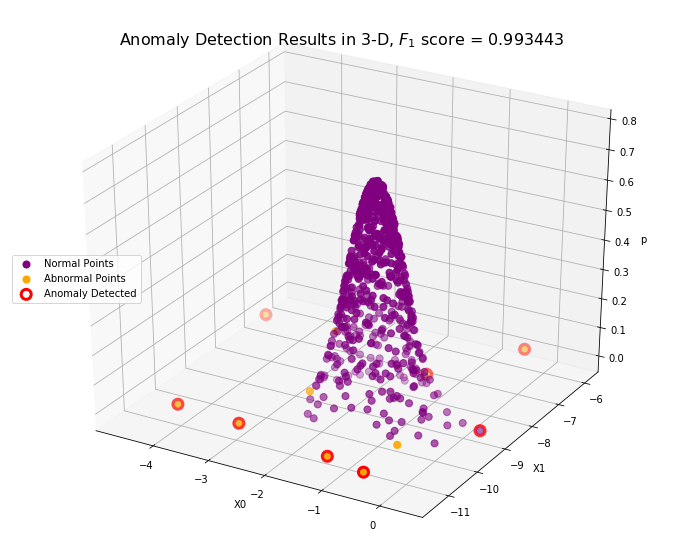

In [0]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax.grid(True)

ax.scatter3D(X_plot[np.where(X_plot[:,2] == 0.)][:, 0], X_plot[np.where(X_plot[:,2] == 0.)][:, 1], X_plot[np.where(X_plot[:,2] == 0.)][:, 3], c='purple', s=50, label='Normal Points')
ax.scatter3D(X_plot[np.where(X_plot[:,2] == 1.)][:, 0], X_plot[np.where(X_plot[:,2] == 1.)][:, 1], X_plot[np.where(X_plot[:,2] == 1.)][:, 3], c='orange', s=50, label='Abnormal Points')
ax.scatter3D(X_plot[np.where(X_plot[:,4] == 1.)][:, 0], X_plot[np.where(X_plot[:,4] == 1.)][:, 1], X_plot[np.where(X_plot[:,4] == 1.)][:, 3], s=100, edgecolors='red', facecolors='None', linewidth=3, label='Anomaly Detected')

plt.title("Anomaly Detection Results in 3-D, $F_1$ score = %f" % F1, fontsize=16)
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('p')
ax.legend(loc = 6)

plt.show()